# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [1]:
import torchvision.datasets as datasets
from pathlib import Path
from collections import Counter
import torch
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, random_split
import utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import wandb

In [2]:
DATA_DIR = Path("data")

imagenette_dataset = datasets.Imagenette(
    DATA_DIR, download=True
)


100%|██████████| 1.56G/1.56G [03:07<00:00, 8.33MB/s] 


In [3]:
name_classes = imagenette_dataset.classes
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


In [4]:
# Contamos la cantidad de imágenes por clase
labels = [imagenette_dataset.classes[target] for _, target in imagenette_dataset]
conteo = Counter(labels)


In [ ]:
print(f'Cantidad de imágenes en el dataset: {len(labels)}')

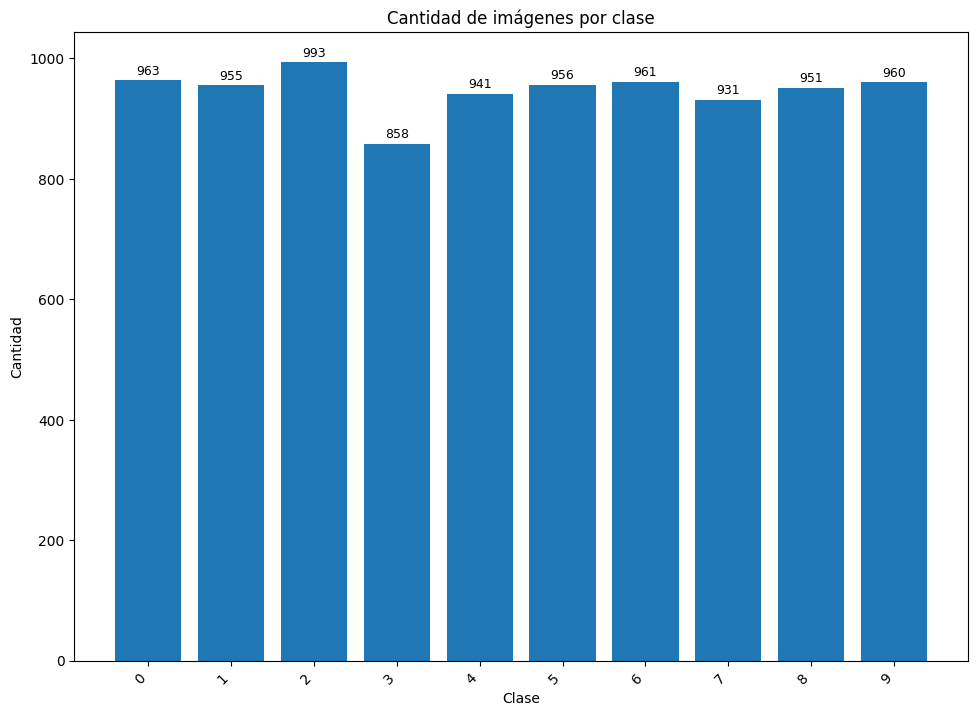

In [6]:
plt.figure(figsize=(10, 10))
plt.bar([", ".join(cls) for cls in conteo.keys()], conteo.values())
plt.xticks(rotation=45, ha='right')
plt.title("Cantidad de imágenes por clase")
plt.ylabel("Cantidad")
plt.xlabel("Clase")
plt.tight_layout()
for i, (k, v) in enumerate(zip(conteo.keys(), conteo.values())):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=9)
plt.xticks(ticks=range(len(conteo)), labels=range(len(conteo)), rotation=45, ha='right')
plt.show()

Si bien observamos que el dataset no contiene la misma cantidad exacta de imágenes por clase podríamos decir que el mismo esta balanceado.
La clase con más datos contiene el 10.5% del total mientras que la que tiene menos datos representa el 9.1%

In [7]:
sizes = [imagenette_dataset[i][0].size for i in range(len(imagenette_dataset))]
conteo_sizes = Counter(sizes)

In [8]:
print(f"Cantidad de tamaños únicos: {len(conteo_sizes.keys())}")

Cantidad de tamaños únicos: 2296


In [9]:
conteo_sizes.most_common()

[((500, 375), 2174),
 ((500, 333), 818),
 ((375, 500), 717),
 ((333, 500), 309),
 ((500, 334), 207),
 ((640, 480), 126),
 ((500, 332), 91),
 ((500, 500), 88),
 ((400, 300), 78),
 ((500, 335), 75),
 ((334, 500), 67),
 ((500, 400), 53),
 ((500, 374), 46),
 ((332, 500), 45),
 ((200, 150), 44),
 ((500, 376), 42),
 ((335, 500), 38),
 ((600, 450), 36),
 ((500, 357), 34),
 ((500, 377), 33),
 ((240, 180), 31),
 ((1600, 1200), 31),
 ((400, 500), 30),
 ((250, 250), 27),
 ((1024, 768), 27),
 ((800, 600), 26),
 ((90, 90), 26),
 ((320, 240), 25),
 ((376, 500), 23),
 ((100, 100), 23),
 ((500, 281), 22),
 ((500, 338), 20),
 ((357, 500), 20),
 ((280, 280), 20),
 ((500, 337), 19),
 ((400, 400), 19),
 ((480, 360), 18),
 ((300, 225), 17),
 ((500, 331), 17),
 ((300, 300), 17),
 ((500, 340), 16),
 ((500, 341), 16),
 ((160, 160), 16),
 ((200, 200), 16),
 ((773, 1162), 16),
 ((1162, 773), 16),
 ((500, 348), 15),
 ((338, 500), 15),
 ((377, 500), 15),
 ((500, 350), 14),
 ((500, 381), 14),
 ((500, 395), 14),
 (

Aplicamos los transforms ToImage() para pasar las imágenes a tensores y Resize() para que todas las imágenes tengan el mismo tamaño (224,224)

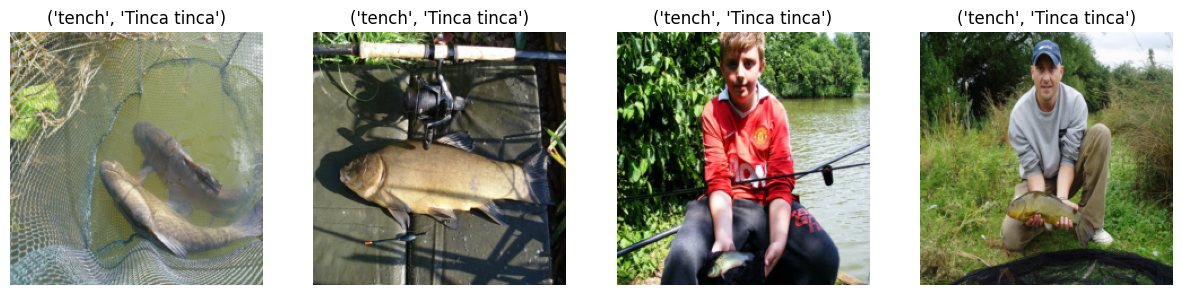

In [10]:
transforms = T.Compose([
    T.ToImage(),
    T.Resize((224, 224))

])

imagenette_dataset_transformado = datasets.Imagenette(
    DATA_DIR, download=False, transform=transforms
)

utils.show_tensor_images([imagenette_dataset_transformado[i][0] for i in range(4)], titles=[imagenette_dataset_transformado.classes[imagenette_dataset_transformado[i][1]] for i in range(4)])


In [11]:
sizes = [imagenette_dataset_transformado[i][0].size() for i in range(len(imagenette_dataset_transformado))]

In [12]:
conteo_sizes_2 = Counter(sizes)
conteo_sizes_2

Counter({torch.Size([3, 224, 224]): 9469})

Luego de aplicadas las transformaciones observamos que solamente tenemos tensores de 1 forma [3, 224, 224]. El 3 corresponde a la cantidad de canales por ser imágenes RGB.
Aplicaremos la tranformacion Grayscale para pasar las imagenes a escala de grises

In [13]:
transforms = T.Compose([
    T.ToImage(),
    T.Grayscale(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((224, 224))

])

imagenette_dataset_train = datasets.Imagenette(
    DATA_DIR, download=False,split = 'train', transform=transforms
)

imagenette_dataset_val = datasets.Imagenette(
    DATA_DIR, download=False,split = 'val', transform=transforms
)

In [14]:
sizes_final = [imagenette_dataset_train[i][0].size() for i in range(len(imagenette_dataset_train))]


In [15]:
conteo_sizes_final = Counter(sizes_final)
conteo_sizes_final

Counter({torch.Size([1, 224, 224]): 9469})

In [16]:
imagenette_dataset_train, imagenette_dataset_test = random_split(
    imagenette_dataset_train, [0.8, 0.2]
)

Entrenamiento

In [17]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 2  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 2


In [18]:
BATCH_SIZE = 128  # tamaño del batch

Definimos la funcion get_dataloaders para crear los dataloaders de entrenamiento, validación y test

In [19]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        imagenette_dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        imagenette_dataset_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        imagenette_dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

## Red convolucional simple sin regularizar

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, input, n_classes):
        super().__init__()
        self.conv = nn.Sequential(
            #224*224
            nn.Conv2d(input[0], 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #112*112
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #56*56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            #28*28
            )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, n_classes),
        )
    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x




Instanciamos el modelo

In [21]:
# Instanciar el modelo
model = SimpleCNN(train_loader.dataset[0][0].shape, nclasses).to(DEVICE)
print(model)

SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [22]:
# Funciones de entrenamiento/validación rápidas (para prueba)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [23]:
train_errors, val_errors = utils.train(model, optimizer=optimizer, criterion=criterion, do_early_stopping=False,train_loader=train_loader, val_loader=val_loader, device=DEVICE, epochs=10)

Epoch: 001 | Train Loss: 2.01749 | Val Loss: 1.84694
Epoch: 002 | Train Loss: 1.63355 | Val Loss: 1.61572
Epoch: 003 | Train Loss: 1.34420 | Val Loss: 1.46991
Epoch: 004 | Train Loss: 1.03078 | Val Loss: 1.57194
Epoch: 005 | Train Loss: 0.68643 | Val Loss: 1.59893
Epoch: 006 | Train Loss: 0.33887 | Val Loss: 1.87881
Epoch: 007 | Train Loss: 0.15893 | Val Loss: 2.48511
Epoch: 008 | Train Loss: 0.05571 | Val Loss: 2.83931
Epoch: 009 | Train Loss: 0.02919 | Val Loss: 3.35241
Epoch: 010 | Train Loss: 0.03829 | Val Loss: 3.27818


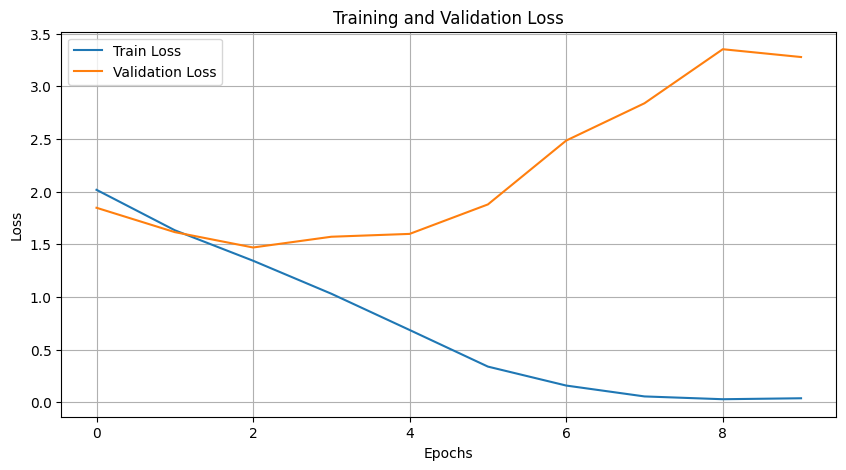

Accuracy: 0.5383

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.69      0.62      0.65       184
           1       0.66      0.53      0.59       183
           2       0.57      0.57      0.57       200
           3       0.32      0.34      0.33       173
           4       0.64      0.58      0.61       212
           5       0.39      0.64      0.48       169
           6       0.58      0.54      0.56       196
           7       0.41      0.46      0.44       171
           8       0.49      0.56      0.52       189
           9       0.81      0.53      0.64       216

    accuracy                           0.54      1893
   macro avg       0.56      0.54      0.54      1893
weighted avg       0.57      0.54      0.54      1893



In [24]:
utils.plot_taining(train_errors, val_errors)
utils.model_calassification_report(model, test_loader, DEVICE, nclasses)

Tanto en el log que se imprime durante el entrenamiento como en el grafico, se observa claramente como a partir de la 4ta epoca, el modelo comienza a sobreajustar, por lo que creamos una nueva red utilizando las siguientes técnicas de regularización buscando evitar el sobreajuste.



*   **Dropout**: Colocamos una capa de dropout luego de cada activación de las capas convolucionales y también a la salida de las capas lineales del clasificador.

*   **Batch Normalization**: Colocamos capas BatchNorm2d luego de cada capa convolucional así como también luego de las capas lineales del clasificador.

* **Early Stopping**: Entrenamos el modelo con early stopping definiendo la paciencia en 10 epocas.



In [25]:
class RegularizedCNN(nn.Module):
    def __init__(self, input, n_classes, dropout_rate=0.5):
        super().__init__()
        self.conv = nn.Sequential(
            # 224*224
            nn.Conv2d(input[0], 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 112*112
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 56*56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 28*28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x



In [26]:
model_reg = RegularizedCNN(train_loader.dataset[0][0].shape, nclasses).to(DEVICE)
print(model_reg)

RegularizedCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout2d(p=0.2, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [27]:
criterion_reg = nn.CrossEntropyLoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3)

In [31]:
train_errors_reg, val_errors_reg = utils.train(
    model_reg,
    optimizer=optimizer_reg,
    criterion=criterion_reg,
    do_early_stopping=True,
    patience=10,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    epochs=30
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 0 has a total capacity of 5.61 GiB of which 607.94 MiB is free. Process 2827846 has 5.01 GiB memory in use. Of the allocated memory 4.23 GiB is allocated by PyTorch, and 679.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
utils.plot_taining(train_errors_reg, val_errors_reg)
utils.model_calassification_report(model_reg, test_loader, DEVICE, nclasses)

## Utilizamos Weight & Bias

Utilizamos la herramienta Weight & Bias para entrenar el modelo con distintos hiperparámetros observando su performance

In [ ]:
WANDB_TEAM_NAME = "[joacoguerrae-ort]"
WANDB_PROJECT = "[wandb-labo1-guerra-sanes]"
wandb.login()

In [ ]:
class RegularizedCNN_Wandb(nn.Module):
    def __init__(self, input, n_classes, dropout_rate=0.5):
        super().__init__()
        self.conv = nn.Sequential(
            # 224*224
            nn.Conv2d(input[0], 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch Normalization
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 112*112
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # 56*56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 28*28
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.classifier(x)
        return x

# Crear el modelo con regularización
modelo_regularizado_wandb = RegularizedCNN_Wandb(train_loader.dataset[0][0].shape, nclasses, dropout_rate=0.5).to(DEVICE)
print(modelo_regularizado_wandb)

# Optimizer con weight decay (L2 regularization)
optimizer_reg = optim.Adam(modelo_regularizado_wandb.parameters(), lr=1e-3, weight_decay=1e-4)

Configuración del sweep:

In [ ]:
sweep_config = {
    "name": "sweep-imagenette-regularized",
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-2
        },
        "optimizer": {
            "values": ["adam", "sgd"]
        },
        "batch_size": {
            "values": [32, 64, 128, 256]
        },
        "dropout_rate": {
            "distribution": "uniform",
            "min": 0.2,
            "max": 0.7
        },
        "weight_decay": {
            "distribution": "log_uniform_values",
            "min": 1e-6,
            "max": 1e-3
        },
        "momentum": {
            "distribution": "uniform",
            "min": 0.85,
            "max": 0.99
        },

    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 5
    }
}


In [ ]:
def train_with_wandb(config=None):
    with wandb.init(config=config):
        # Obtener la configuración del sweep
        config = wandb.config

        # Crear dataloaders con el batch_size del sweep
        train_loader_sweep, val_loader_sweep, test_loader_sweep = get_dataloaders(
            batch_size=config.batch_size,
            num_workers=NUM_WORKERS
        )

        # Crear el modelo con los parámetros del sweep
        model = RegularizedCNN_Wandb(
            train_loader_sweep.dataset[0][0].shape,
            nclasses,
            dropout_rate=config.dropout_rate
        ).to(DEVICE)

        # Definir el optimizador según la configuración
        if config.optimizer == "adam":
            optimizer = optim.Adam(
                model.parameters(),
                lr=config.learning_rate,
                weight_decay=config.weight_decay
            )
        elif config.optimizer == "sgd":
            optimizer = optim.SGD(
                model.parameters(),
                lr=config.learning_rate,
                momentum=config.momentum,
                weight_decay=config.weight_decay
            )

        # Criterio de pérdida
        criterion = nn.CrossEntropyLoss()

        # Entrenar el modelo
        train_errors, val_errors = utils.train(
            model,
            optimizer=optimizer,
            criterion=criterion,
            do_early_stopping=True,
            train_loader=train_loader_sweep,
            val_loader=val_loader_sweep,
            device=DEVICE,
            epochs=30,
            patience=10
        )

        if val_errors:
            best_val = float(min(val_errors))
            wandb.run.summary["val_loss"] = best_val

        # Evaluamos el conjunto en test
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader_sweep:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_accuracy = 100. * correct / total
        test_loss = test_loss / len(test_loader_sweep)

        # Log de métricas finales
        wandb.log({
            "test_accuracy": test_accuracy,
            "test_loss": test_loss
        })

        print(f"Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
#Creamos el sweep
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

print(f"Sweep ID: {sweep_id}")

In [ ]:
wandb.agent(sweep_id, function=train_with_wandb, count=20)

In [ ]:
#api = wandb.Api()
#sweep = api.sweep("joacoguerrae-ort/[wandb-labo1-guerra-sanes]/9zt0jvn4")

In [ ]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)